In [1]:
import torch
from scratch import ArtDataset
from torch.utils.data import Dataset, DataLoader, random_split
import math
import torch.nn as nn
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
from model import create_vocab_csv, text_to_tensor

## Initialize the Dataset

In [2]:
# initialize the dataset and the dataloader
dataset = ArtDataset()

Dataset loaded successfully!


# Split dataset into train, validation (dev), and test sets
Train: 95%
Validation: 2.5%
Test: 2.5%

In [3]:
# Define the dataset sizes
total_size = len(dataset)
train_size = int(0.95 * total_size)
val_size = int(0.025 * total_size)
test_size = total_size - train_size - val_size

In [4]:
print(train_size, val_size, test_size)

316406 8326 8327


In [5]:
# Split dataset into train, validation (dev), and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [6]:
print(len(train_dataset))

316406


In [ ]:
# Higher batch size seems to make the model train faster, but converge happens slower 
batch = 256  

# Create dataloaders for the training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=2)

## Load The GloVe Embeddings
Below we load the GloVe embeddings, and define functions to search the vicinity of given target words. 

In [8]:
# Load GloVe embeddings
def load_glove_embeddings(filepath, embedding_dim):
    embeddings = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Set path to GloVe file and embedding dimension
glove_path = "glove.6B.50d.txt"  # Update this to your GloVe file path
embedding_dim = 50
glove_embeddings = load_glove_embeddings(glove_path, embedding_dim)

In [9]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [10]:
def find_k_nearest_neighbors(word, glove_embeddings, k=5):
    if word not in glove_embeddings:
        print(f"{word} not found in GloVe embeddings.")
        return []

    # Get the embedding vector of the target word
    target_vector = glove_embeddings[word]
    
    # Calculate similarity between the target word and every other word in the embeddings
    similarities = {}
    for other_word, other_vector in glove_embeddings.items():
        if other_word != word:
            similarity = cosine_similarity(target_vector, other_vector)
            similarities[other_word] = similarity

    # Sort words by similarity and get the top k
    nearest_neighbors = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:k]
    return nearest_neighbors

In [11]:
print(find_k_nearest_neighbors("art", glove_embeddings, k=5))

[('contemporary', np.float32(0.8596234)), ('works', np.float32(0.83878714)), ('arts', np.float32(0.8278873)), ('museum', np.float32(0.82194173)), ('collection', np.float32(0.8105687))]


In [12]:
cosine_similarity(glove_embeddings["arbus"], glove_embeddings["rare"])

np.float32(-0.2013035)

## Define the Models
We define the model to have 6 fully-connected layers, with 16, 16, 16, 16, 16, 8, 1 hidden units

In [17]:
class ArtPricePredictor(nn.Module):
    def __init__(self, features_dim):
        super(ArtPricePredictor, self).__init__()
        
        # Fully connected layers for combined features
        self.fc1 = nn.Linear(features_dim, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 16)
        self.fc5 = nn.Linear(16, 8)
        self.fc6 = nn.Linear(8, 1)

    def forward(self, x):
        # Forward pass through fully connected layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)  # Final output for price prediction
        return x

In [ ]:
class ArtPriceClassifier(nn.Module):
    def __init__(self, features_dim):
        super(ArtPricePredictor, self).__init__()
        
        # Fully connected layers for combined features
        self.fc1 = nn.Linear(features_dim, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 16)
        self.fc5 = nn.Linear(16, 8)
        self.fc6 = nn.Linear(8, 1)

    def forward(self, x):
        # Forward pass through fully connected layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)  # Final output for price prediction
        return x

## Instantiate the Art Price Predictor Model 

In [ ]:
# Extract the dimensions of the inputs 
vocab_size_artist = dataset.artist_vocab_len + 1
vocab_size_title = dataset.title_vocab_len + 1
numerical_features_dim = dataset.numerics.shape[1]
print(f' Artist Vocab Size: {vocab_size_artist}\n Title Vocab Size: {vocab_size_title}\n Number of numerical features: {numerical_features_dim}')

In [83]:
# Set model hyperparameters 
learning_rate =0.0000001

In [19]:
# Define the model
x, y = dataset.__getitem__(0)
model = ArtPricePredictor(x.size()[0])
print(model)

ArtPricePredictor(
  (fc1): Linear(in_features=13, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=8, bias=True)
  (fc6): Linear(in_features=8, out_features=1, bias=True)
)


In [84]:
# Define percentage error loss
# We use percentage error so that errors on large prices are treated more leniently than errors on small prices 
class MAPE(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(MAPE, self).__init__()
        self.epsilon = epsilon  # Small constant to avoid division by zero

    def forward(self, predictions, targets):
        # Calculate MAPE
        percentage_errors = torch.abs((targets - predictions) / (targets + self.epsilon))
        mape = 100.0 * torch.mean(percentage_errors)
        return mape

criterion = MAPE() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.90, 0.999))  # ADAM Optimization (first beta controls momentum)

# APPLY LEARNING RATE DECAY 
# Reduces the learning rate by a factor of gamma every step_size epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.99)

In [85]:
print(model)

ArtPricePredictor(
  (fc1): Linear(in_features=13, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=8, bias=True)
  (fc6): Linear(in_features=8, out_features=1, bias=True)
)


In [21]:
# make a prediction and extract the actual value
prediction = model(dataset.x[0:2])
label = dataset.price[0:2]

# evaluate the loss
print("Loss ", criterion(prediction, label))
print("Model Prediction: ", prediction)
print("Actual Label: ", label)

Loss  tensor(1481.3180, grad_fn=<MulBackward0>)
Model Prediction:  tensor([[0.1241],
        [0.1237]], grad_fn=<AddmmBackward0>)
Actual Label:  tensor([[-0.0083],
        [-0.0097]])


## Train the model using Mini-Batch Gradient Descent with ADAM

In [22]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()  # Set model to training mode
    running_loss = 0.0
    batch_losses = []  # Store each batch's loss
    step_num = 0

    # loops over all mini-batches in the dataloader 
    for x, price in dataloader:
        
        # Forward pass
        price_pred = model(x)
        loss = criterion(price_pred, price)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Zero the gradients
        optimizer.zero_grad()
        
        # Accumulate the loss
        batch_losses.append(loss.item())
        if (step_num % 100) == 0: 
            print(f'Loss at step {step_num}: {loss.item()}')

        # increment the step count 
        step_num += 1
    
    return batch_losses

Training one epoch...
Loss at step 0: 6723.677734375
Loss at step 100: 3818.71826171875
Loss at step 200: 2377.814208984375
Loss at step 300: 1246.66455078125
Loss at step 400: 807.837646484375
Loss at step 500: 919.9601440429688
Loss at step 600: 347.30743408203125
Loss at step 700: 266.62493896484375
Loss at step 800: 25694.98046875
Loss at step 900: 1278.3765869140625
Loss at step 1000: 591.1775512695312
Loss at step 1100: 657.5821533203125
Loss at step 1200: 228.69334411621094


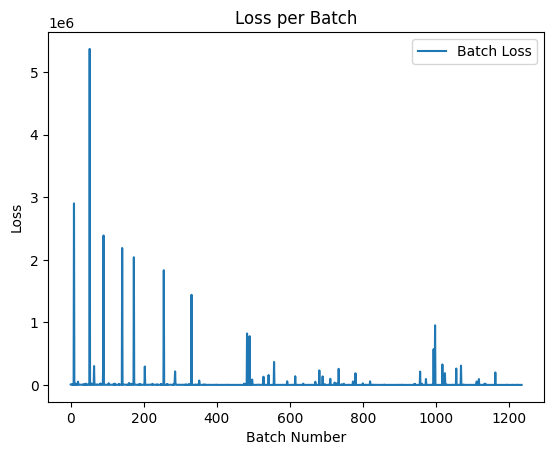

In [23]:
# One example training epopppch 
print("Training one epoch...")
losses = train_one_epoch(model, train_loader, criterion, optimizer)

# Plot the loss curve
plt.plot(losses, label="Batch Loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Loss per Batch")
plt.legend()
plt.show()

In [96]:
# Calculates the model's total percentage error on a given dataset 
def evaluate_percent(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    total_percentage_error = 0.0
    num_samples = 0
    
    with torch.no_grad():
        for x, price in dataloader:
            # Calculate the model's prediction on the given artist, title and numerics
            outputs = model(x)
            
            # Calculate absolute percentage error
            abs_percentage_error = torch.abs((outputs - price) / price) * 100
            
            # Accumulate the sum of percentage errors
            total_percentage_error += abs_percentage_error.sum().item()
            
            # Count the number of samples
            num_samples += price.size(0)
    
    # Calculate the mean percentage error
    mean_percentage_error = total_percentage_error / num_samples
    return mean_percentage_error

In [53]:
print(f"Error of the model without training on the training set: {evaluate_percent(model, train_loader, criterion)}%")
print(f"Error of the model without training on the validation set: {evaluate_percent(model, val_loader, criterion)}%")

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/pytorch/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/pytorch/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/aoden/PycharmProjects/PyTorch Art Project/scratch.py", line 131, in <module>
    dataset = ArtDataset()
              ^^^^^^^^^^^^
  File "/Users/aoden/PycharmProjects/PyTorch Art Project/scratch.py", line 94, in __init__
    avg_cosine_similarity_with_museum(title, glove_embeddings) for title in title_col
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/aoden/PycharmProjects/PyTorch Art Project/scratch.py", line 56, in avg_cosine_similarity_with_museum
    similarities.append(cosine_similarity(embeddi

KeyboardInterrupt: 

In [140]:
# Calculate the average loss of the model 
def evaluate_loss(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    with torch.no_grad():
        for x, price in dataloader:
            # Forward pass
            outputs = model(artist, title, numerics)
            loss = criterion(outputs, price)
            
            # Accumulate the loss
            running_loss += loss.item()
    
    return running_loss / len(dataloader)

In [141]:
print(f'Mean Squared Error of the untrained model on Validation Set: {evaluate_loss(model, val_loader, criterion)}')

Median Price: $2830.89
Mean Price: $31777.83
Normalized to MEDIAN
Dataset loaded successfully!
Median Price: $2830.89
Mean Price: $31777.83
Normalized to MEDIAN
Dataset loaded successfully!
Mean Squared Error of the untrained model on Validation Set: 1807.3191605196655


In [86]:
##### Training Loop 
num_epochs = 1000
loss_plot = []  # keep a vector to plot the loss as we go 
average = []

for epoch in range(num_epochs):
    batch_losses = train_one_epoch(model, train_loader, criterion, optimizer)
    loss_plot.extend(batch_losses)  # Store losses for each batch
    
    # Print average loss for the epoch
    avg_epoch_loss = sum(batch_losses) / len(batch_losses)
    average.append(avg_epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg Train Loss: {avg_epoch_loss}")

    # Update the learning rate 
    scheduler.step()

    # if the average epoch loss goes below human error significantly, stop training 
    if avg_epoch_loss < 30: 
        break

    if (epoch % 100) == 0: 
        torch.save(model.state_dict(), 'model_weights.txt')

# Plot the loss curve
plt.plot(loss_plot, label="Batch Loss")
plt.plot(average, label="Average Batch Loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Loss per Batch")
plt.legend()
plt.show()

Loss at step 0: 98.10074615478516
Loss at step 100: 98.79345703125
Loss at step 200: 98.26093292236328
Loss at step 300: 98.58424377441406
Loss at step 400: 100.46464538574219
Loss at step 500: 98.22772979736328
Loss at step 600: 99.21451568603516
Loss at step 700: 98.0748519897461
Loss at step 800: 100.44029998779297
Loss at step 900: 102.77926635742188
Loss at step 1000: 98.0472412109375
Loss at step 1100: 100.29419708251953
Loss at step 1200: 98.06096649169922
Epoch 1/1000, Avg Train Loss: 99.5037512732941
Loss at step 0: 99.05168151855469
Loss at step 100: 98.28726196289062
Loss at step 200: 99.45365905761719
Loss at step 300: 98.72306823730469
Loss at step 400: 99.27804565429688
Loss at step 500: 100.13745880126953
Loss at step 600: 99.2129135131836
Loss at step 700: 98.7256088256836
Loss at step 800: 98.78205871582031
Loss at step 900: 106.23340606689453
Loss at step 1000: 98.32015991210938
Loss at step 1100: 99.21719360351562
Loss at step 1200: 98.65901184082031
Epoch 2/1000, Av

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/pytorch/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/pytorch/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/aoden/PycharmProjects/PyTorch Art Project/scratch.py", line 42, in <module>
    glove_embeddings = load_glove_embeddings(glove_path, embedding_dim)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/aoden/PycharmProjects/PyTorch Art Project/scratch.py", line 32, in load_glove_embeddings
    vector = np.asarray(values[1:], dtype='float32')
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

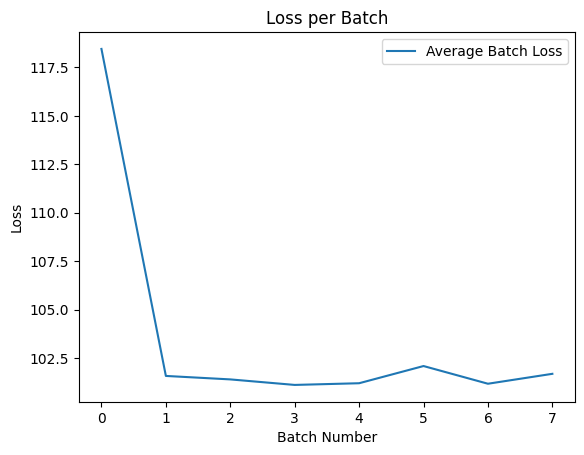

In [82]:
plt.plot(average, label="Average Batch Loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Loss per Batch")
plt.legend()
plt.show()

In [81]:
def prediction_to_real_price(price_tensor): 
    return (price_tensor * dataset.price_std) + dataset.price_median

# Sample the Training Set 
index = 16
x_test, price_test = dataset.__getitem__(index)
artist_str, title_str = dataset.__getstring__(index)
print(f"Artist: {artist_str}")
print(f"Title: {title_str}")
print(f"Real Price: ${prediction_to_real_price(price_test).item():.2f}")
prediction = model(x_test.view(1, -1))
print(f"Model Prediction: ${prediction_to_real_price(prediction).item():.2f}")
with torch.no_grad(): 
    print(criterion(price_test, prediction).item())

Artist: Circle of A. de Simone
Title: The Motor Yacht Dolphin , Royal Thames Yacht Club, in the Bay of Naples
Real Price: $549.16
Model Prediction: $2830.93
5428083.0


In [48]:

print(f"Artist: {artist_str}")
print(f"Title: {title_str}")
print(f"Real Price: ${prediction_to_real_price(price_test).item():.2f}")
prediction = model(artist_test.view(1, -1), title_test.view(1, -1), numerics_test.view(1, -1))
print(f"Model Prediction: ${prediction_to_real_price(prediction).item():.2f}")

Artist: A pink lustre 'Freemason's' jug
Title: nan
Real Price: $219.52


NameError: name 'artist_test' is not defined

In [180]:
with torch.no_grad(): 
    print(criterion(price_test, prediction))

tensor(54.4121)


In [40]:
print("Real Price Normalized: ", price_test)
print("Model Prediction Normalized: ", prediction)

Real Price Normalized:  tensor([-0.0092])
Model Prediction Normalized:  tensor([[-2.1695e-08]], grad_fn=<AddmmBackward0>)


In [38]:
# Print all weights and biases
for name, param in model.state_dict().items():
    print(f"{name}:\n{param}\n")

fc1.weight:
tensor([[-0.2612, -0.3165, -0.0925, -0.1503, -0.1302,  0.0803,  0.1983, -0.0735,
          0.0091,  0.3834, -0.1505,  0.0686,  0.0193],
        [ 0.2101,  0.3574,  0.4466, -0.3402,  0.1273,  0.0058, -0.3784,  0.0053,
         -0.5275,  0.3315, -0.1071, -0.1518, -0.0346],
        [-0.0795, -0.2030,  0.3063, -0.0636, -0.1748,  0.0216,  0.0373, -0.1911,
         -0.2639,  0.0804,  0.1417, -0.0013, -0.0812],
        [ 0.1090,  0.1107, -0.2536,  0.3599, -0.1825,  0.2160,  0.1724, -0.4350,
          0.2164, -0.4358,  0.1931,  0.3384,  0.0540],
        [-0.3601, -0.1574, -0.1143, -0.0907, -0.2680,  0.1386,  0.2232, -0.1045,
          0.1425, -0.0342,  0.0586, -0.0394, -0.0060],
        [-0.1171, -0.5389,  0.1044,  0.1699, -0.1923, -0.3639, -0.0117, -0.0824,
         -0.1775, -0.2600, -0.2471,  0.2647, -0.0533],
        [ 0.1294,  0.0744, -0.0263,  0.4745, -0.2291,  0.1951,  0.3845,  0.1570,
          0.2338, -0.2118,  0.5391,  0.0463,  0.4172],
        [-0.2072, -0.0140, -0.0899, 

Compute human error

In [68]:
import pandas as pd

# Load the CSV file
file_path = 'clean_art.csv'
data = pd.read_csv(file_path)

# Calculate the human predicted price (midpoint)
data['Human Predicted Price'] = (data['Real LB Estimate USD'] + data['Real UB Estimate USD']) / 2

# Calculate the absolute percentage error for each row
data['Absolute Percentage Error'] = abs(data['Human Predicted Price'] - data['Real Price USD']) / data['Real Price USD']

# Calculate the mean of the absolute percentage error (MAPE)
mape = data['Absolute Percentage Error'].mean() * 100

# Output the result
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 39.08%
